## Análise dos Eventos

Este notebook lê a base de eventos (`data/eventos/eventos_completo.csv`) - que são agrupamentos geo-espaciais de congestionamentos e acidentes - e desenvolve análises descritivas inicias (volumes e caracteristicas dos registros)

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import numpy as np
from datetime import datetime, timedelta

from sklearn.cluster import DBSCAN

import aux.agrupamento as agrup
import aux.arestas as arestas
from importlib import reload
reload(agrup)
reload(arestas)

<module 'aux.arestas' from 'c:\\Users\\gigec\\OneDrive\\Documentos\\Pedro\\MBA\\TCC\\src\\aux\\arestas.py'>

In [2]:
df = pd.read_csv('data/eventos/eventos_completo.csv')
df['momento_inicial'] = pd.to_datetime(df['momento_inicial'])
df['momento_final'] = pd.to_datetime(df['momento_final'])

df['hora_inicial'] = pd.to_datetime(df['hora_inicial'], format='%H:%M:%S')
df['hora_acidente'] = pd.to_datetime(df['hora_acidente'], format='%H:%M:%S')

# Extrair a hora dos registros
df['hora_inicial_int'] = df['hora_inicial'].dt.hour
df['hora_final_int'] = df['momento_final'].dt.hour
df['hora_acidente_int'] = df['hora_acidente'].dt.hour
df['duracao'] = (df['momento_final'] - df['momento_inicial']).dt.total_seconds() / (60*60)

# Criando uma nova coluna 'mes_ano' para agrupar por mês
df['mes_ano'] = df['momento_inicial'].dt.to_period('M')

print(len(df)) # 100391 83317

83317


### Características dos eventos

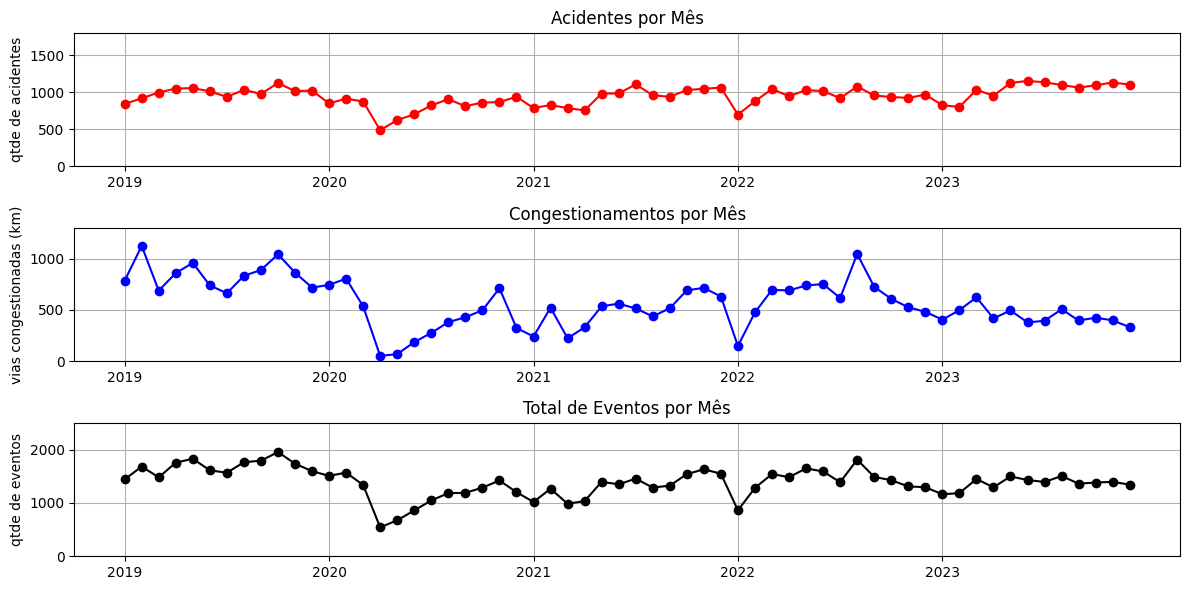

In [3]:
registros_por_mes = df.groupby('mes_ano').size()
soma_tamanhos_por_mes = df.groupby('mes_ano')['tamanho'].sum() / 1000
acidentes_por_mes = df.groupby('mes_ano')['n_acidentes'].sum()


# Criando subplots
fig, ax = plt.subplots(3, 1, figsize=(12,6))


ax[0].plot(soma_tamanhos_por_mes.index.astype(str), acidentes_por_mes, marker='o', color='r')
ax[0].set_title('Acidentes por Mês')
ax[0].set_ylabel('qtde de acidentes')
ax[0].grid(True)
ax[0].set_xticks(ax[0].get_xticks()[::12], labels = range(2019, 2024)) 
ax[0].tick_params(axis='x')
ax[0].set_ylim(0, 1800)

# Plotando a soma dos tamanhos no segundo gráfico
ax[1].plot(soma_tamanhos_por_mes.index.astype(str), soma_tamanhos_por_mes, marker='o', color='b')
ax[1].set_title('Congestionamentos por Mês')
ax[1].set_ylabel('vias congestionadas (km)')
ax[1].grid(True)
ax[1].set_xticks(ax[1].get_xticks()[::12], labels = range(2019, 2024)) 
ax[1].tick_params(axis='x')
ax[1].set_ylim(0, 1300)  # Faz o eixo y começar do zero

# Plotando a quantidade de registros no primeiro gráfico
ax[2].plot(registros_por_mes.index.astype(str), registros_por_mes, marker='o', color='black')
ax[2].set_title('Total de Eventos por Mês')
ax[2].set_ylabel('qtde de eventos')
ax[2].grid(True)
ax[2].set_xticks(ax[2].get_xticks()[::12], labels = range(2019, 2024)) 
ax[2].tick_params(axis='x')
ax[2].set_ylim(0, 2500)  # Faz o eixo y começar do zero
# Ajustando o layout para que os rótulos não se sobreponham
plt.tight_layout()
plt.show()

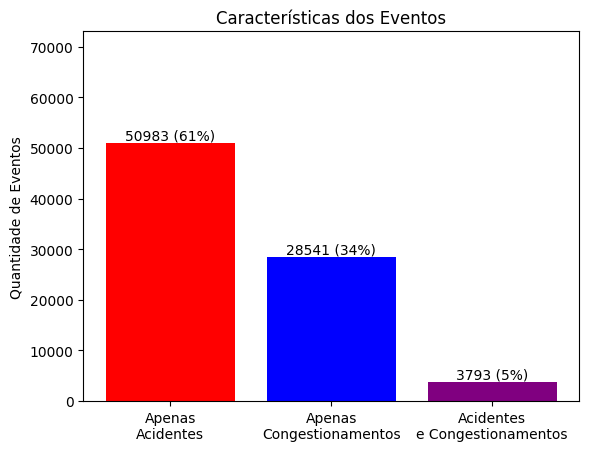

In [4]:
so_acidentes = (df['tamanho'] == 0) & (df['n_acidentes'] > 0)
so_congestionamento = (df['tamanho'] > 0) & (df['n_acidentes'] == 0)
ambos = (df['tamanho'] > 0) & (df['n_acidentes'] > 0)

# Quantidade de registros para cada condição
so_acidentes = df[so_acidentes].shape[0]
so_congestionamento = df[so_congestionamento].shape[0]
ambos = df[ambos].shape[0]

counts = [so_acidentes, so_congestionamento, ambos]
labels = ['Apenas\nAcidentes', 'Apenas\nCongestionamentos', 'Acidentes\ne Congestionamentos']
colors = ['red', 'blue', 'purple']

fig, ax = plt.subplots()
bars = ax.bar(labels, counts, color=colors)

# Adicionando o texto com os valores nas barras
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0, yval, f'{int(yval)} ({round(int(yval)/ len(df) * 100)}%)' , ha='center', va='bottom')

plt.ylabel('Quantidade de Eventos')
plt.title('Características dos Eventos')
plt.ylim(0, 73000)
plt.show()

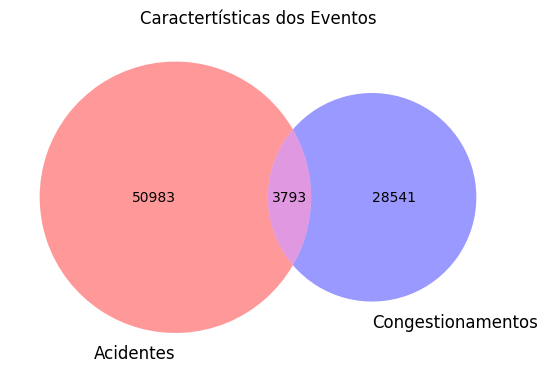

In [5]:
venn2(subsets=(so_acidentes, so_congestionamento, ambos),
      set_labels=('Acidentes', 'Congestionamentos'), set_colors=('red', 'blue', ))

plt.title('Caractertísticas dos Eventos')
plt.show()

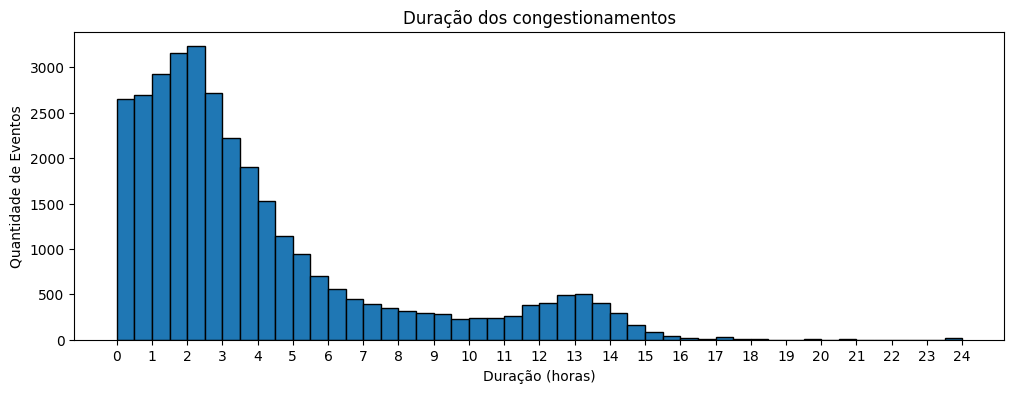

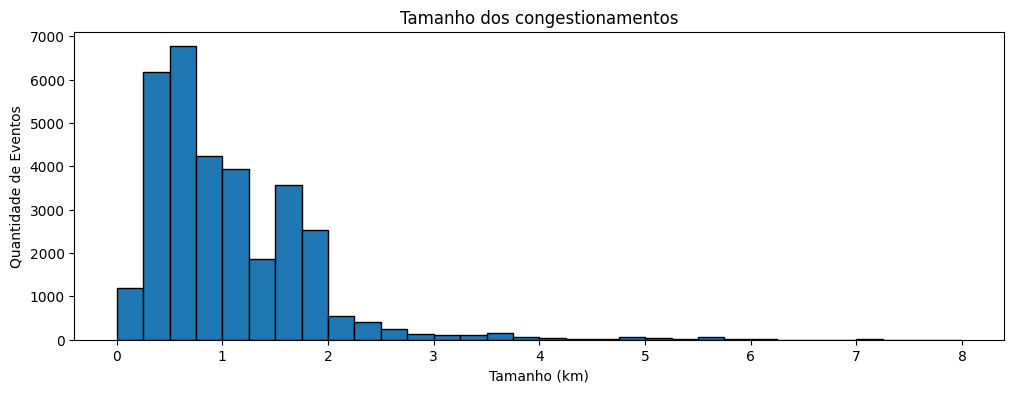

In [6]:
aux = df.loc[df['tamanho'] > 0]

plt.figure(figsize=(12, 4))
plt.hist(aux['duracao'], bins=[x / 2 for x in range(0, 2 * int(aux['duracao'].max()) + 1, 1)], edgecolor='black')

plt.xticks(ticks = range(0, int(aux['duracao'].max()) + 1))

# Adicionar rótulos e título
plt.xlabel('Duração (horas)')
plt.ylabel('Quantidade de Eventos')
plt.title('Duração dos congestionamentos')

# Mostrar o gráfico
plt.show()


plt.figure(figsize=(12, 4))
plt.hist(aux['tamanho'], bins=range(0, int(aux['tamanho'].max() + 1), 250), edgecolor='black')
plt.xticks(ticks = range(0, int(aux['tamanho'].max()) + 1, 1000), labels = range(int(aux['tamanho'].max() / 1000) + 1))

# Adicionar rótulos e título
plt.xlabel('Tamanho (km)')
plt.ylabel('Quantidade de Eventos')
plt.title('Tamanho dos congestionamentos')

# Mostrar o gráfico
plt.show()

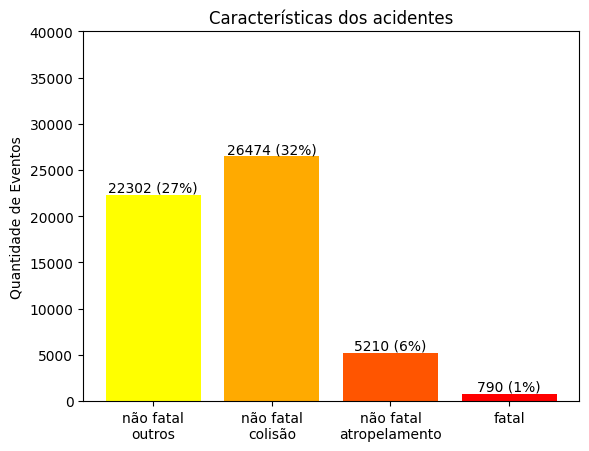

In [7]:
a = len(df.loc[df['tipo_acidente'] == 0])
b = len(df.loc[df['tipo_acidente'] == 1])
c = len(df.loc[df['tipo_acidente'] == 2])
d = len(df.loc[df['tipo_acidente'] == 3])


counts = [a, b, c, d]
labels = ['não fatal\noutros', 'não fatal\ncolisão', 'não fatal\natropelamento', 'fatal']

# Definindo as cores de início e fim
start_color = np.array([1, 1, 0])  # Amarelo (RGB)
end_color = np.array([1, 0, 0])    # Vermelho (RGB)

# Gerando uma transição entre as cores
num_colors = 4
colors = [start_color + (end_color - start_color) * (i / (num_colors - 1)) for i in range(num_colors)]

fig, ax = plt.subplots()
bars = ax.bar(labels, counts, color=colors)

# Adicionando o texto com os valores nas barras
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0, yval, f'{int(yval)} ({round(int(yval)/ len(df) * 100)}%)' , ha='center', va='bottom')

plt.ylabel('Quantidade de Eventos')
plt.title('Características dos acidentes')
plt.ylim(0, 40000)
plt.show()

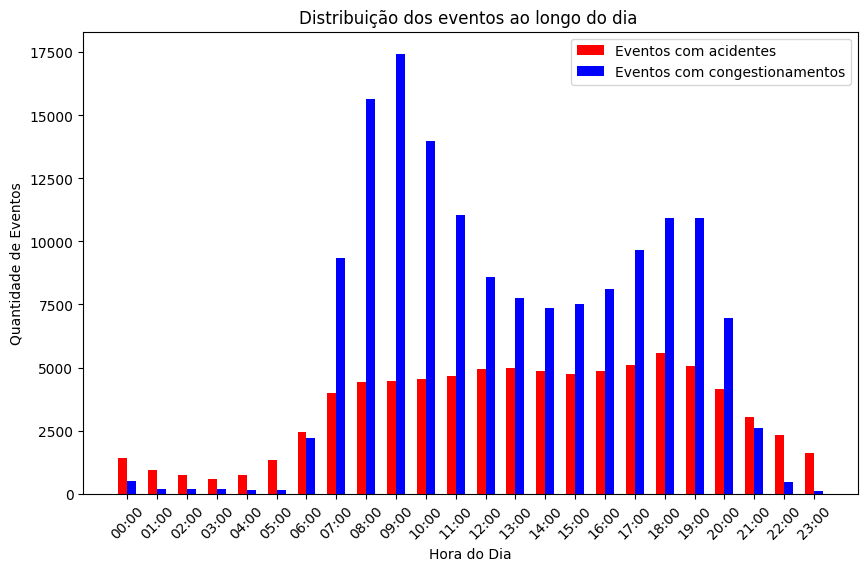

In [8]:
def contar_registros_ativos(df):
    horas_do_dia = list(range(24))
    frequencia_por_hora = pd.Series(0, index=horas_do_dia)
    for hora in horas_do_dia:
        frequencia_por_hora[hora] = ((df['hora_inicial_int'] <= hora) & (df['hora_final_int'] >= hora)).sum()
    return frequencia_por_hora

frequencia_total = contar_registros_ativos(df)
frequencia_acidentes = contar_registros_ativos(df.loc[df['n_acidentes'] > 0])
frequencia_congestionamentos = contar_registros_ativos(df.loc[df['tamanho'] > 0])

# Plotar o gráfico
plt.figure(figsize=(10, 6))

# Gráficos de barras para os dois subconjuntos
plt.bar(frequencia_acidentes.index - 0.15, frequencia_acidentes, width=0.3, label='Eventos com acidentes', color='red', align='center')
plt.bar(frequencia_congestionamentos.index + 0.15, frequencia_congestionamentos, width=0.3, label='Eventos com congestionamentos', color='blue', align='center')

# Configurações do gráfico
plt.title('Distribuição dos eventos ao longo do dia ')
plt.xlabel('Hora do Dia')
plt.ylabel('Quantidade de Eventos')
plt.xticks(range(24), labels=[f'{h:02d}:00' for h in range(24)], rotation = 45)  # Ajustar os labels para exibir as horas corretamente
plt.legend()  # Mostrar a legenda para diferenciar os subconjuntos

# Exibir o gráfico
plt.show()

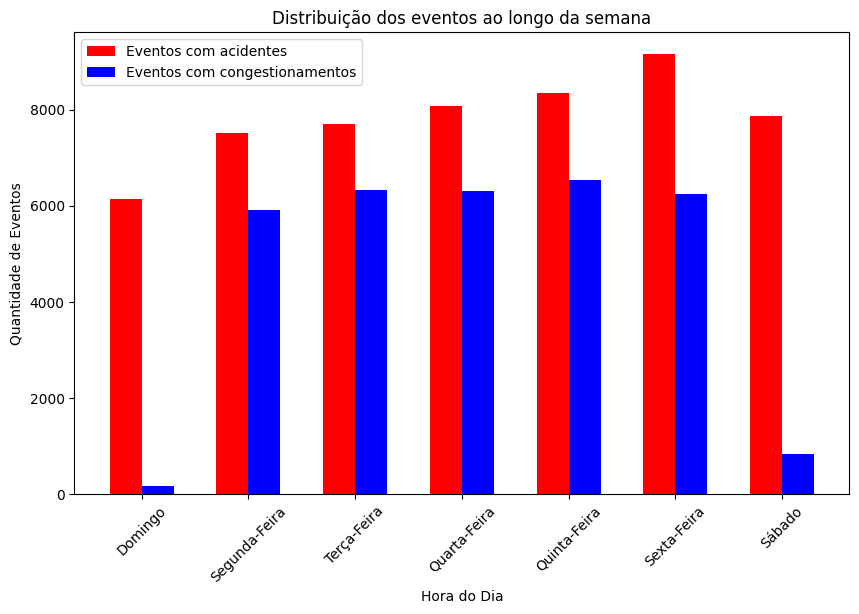

In [9]:
def contar_registros_ativos(df):
    dias = list(range(7))
    frequencia_por_dia = pd.Series(0, index=dias)
    for dia in dias:
        frequencia_por_dia[dia] = (df['dia_semana'] == (dia - 1)%7).sum()
    return frequencia_por_dia

frequencia_total = contar_registros_ativos(df)
frequencia_acidentes = contar_registros_ativos(df.loc[df['n_acidentes'] > 0])
frequencia_congestionamentos = contar_registros_ativos(df.loc[df['tamanho'] > 0])

# Plotar o gráfico
plt.figure(figsize=(10, 6))

# Gráficos de barras para os dois subconjuntos
plt.bar(frequencia_acidentes.index - 0.15, frequencia_acidentes, width=0.3, label='Eventos com acidentes', color='red', align='center')
plt.bar(frequencia_congestionamentos.index + 0.15, frequencia_congestionamentos, width=0.3, label='Eventos com congestionamentos', color='blue', align='center')

# Configurações do gráfico
plt.title('Distribuição dos eventos ao longo da semana')
plt.xlabel('Hora do Dia')
plt.ylabel('Quantidade de Eventos')
plt.xticks(range(7), labels=['Domingo','Segunda-Feira', 'Terça-Feira', 'Quarta-Feira', 'Quinta-Feira', 'Sexta-Feira', 'Sábado'], rotation = 45)  # Ajustar os labels para exibir as horas corretamente
plt.legend()  # Mostrar a legenda para diferenciar os subconjuntos

# Exibir o gráfico
plt.show()

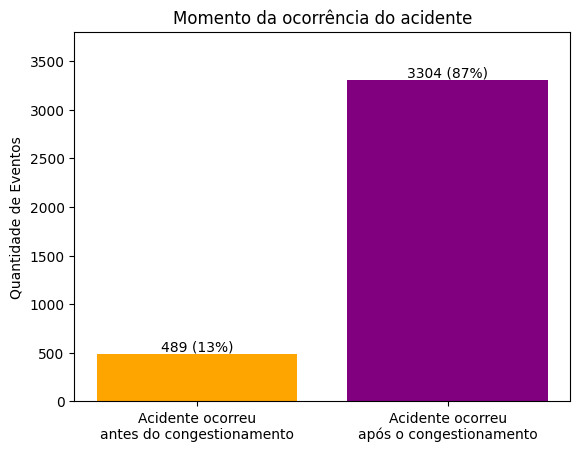

In [10]:
ambos = (df['tamanho'] > 0) & (df['n_acidentes'] > 0)
aux = df[ambos]
aux['diferenca'] = aux['hora_acidente'] - aux['hora_inicial']
aux['diferenca_abs'] = aux['diferenca'].abs()

acidente_antes = len(aux[aux['diferenca_abs'] <= pd.Timedelta(minutes=5)])
acidente_depois = len(aux[aux['diferenca'] > pd.Timedelta(minutes=5)])

counts = [acidente_antes, acidente_depois]
labels = ['Acidente ocorreu\nantes do congestionamento', 'Acidente ocorreu\napós o congestionamento']
colors = ['orange', 'purple']

fig, ax = plt.subplots()
bars = ax.bar(labels, counts, color=colors)

# Adicionando o texto com os valores nas barras
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0, yval, f'{int(yval)} ({round(int(yval)/ len(aux) * 100)}%)' , ha='center', va='bottom')

plt.ylabel('Quantidade de Eventos')
plt.title('Momento da ocorrência do acidente')
plt.ylim(0, 3800)
plt.show()

### Visualização de Alguns eventos

In [11]:
df_arestas = arestas.le_e_processa_arestas('data/arestas/0_arestas_completo.csv')

c:\Users\gigec\OneDrive\Documentos\Pedro\MBA\TCC\src\aux\arestas.py:10: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


23:51:24	Transformando campos de data em numérico (1 min)
23:51:42	Fim da transformacao
23:51:42	Extraindo LineStrings (2 min)
23:53:20	Obtendo ponto médio (1 min)
23:54:10	Separando coordenadas (3 min)
23:56:40	Eliminando duplicidades
			 21400 registros duplicados deletados
			 4986036 registros restantes
23:56:42	Fim Processamento


In [16]:
def plota_evento(df_eventos, df_arestas, index_evento, janela_hora = None):
    evento = df_eventos.iloc[index_evento]
    cluster = evento['cluster']
    hora = evento['momento_inicial'].hour
    dia = pd.to_datetime(evento['momento_inicial']) - timedelta(hours = hora)
    fim = dia + timedelta(hours=24)

    df_dia = df_arestas[(df_arestas['datetime'] >= dia) & (df_arestas['datetime'] <= fim)]
    features = df_dia[['lat', 'lon', 'time_scaled']].values
    clusters = DBSCAN(eps=.0055, min_samples = 2, metric = 'euclidean').fit(features)
    agrup.avalia_clusters(df_dia, features, clusters, plota = False)

    df_cluster = df_dia.loc[df_dia['cluster'] == cluster]

    #agrup.plota_arestas(df_cluster)
    print('*********************\nDuração (h):\t', evento['duracao'])

    if janela_hora != None:
        hora += janela_hora
        arestas.plota_arestas(df_cluster.loc[(df_cluster['datetime'] >= dia + timedelta(hours=hora)) & 
                                        (df_cluster['datetime'] < dia + timedelta(hours=hora + 1))])
    else:
        arestas.plota_arestas(df_cluster)

In [31]:
aux = df.loc[((df['n_acidentes'] > 2) & (df['tamanho'] > 0) & (df['duracao'] < 5))]
print(len(aux))
display(aux.sample(3))

13


,Unnamed: 0.1,Unnamed: 0,cluster,momento_inicial,momento_final,duracao,dia_semana,hora_inicial,tamanho,n_vertices,media_grau,n_acidentes,tipo_acidente,qtde_vitimas,hora_acidente,hora_inicial_int,hora_final_int,hora_acidente_int,mes_ano
14243,1123,1123,0,2019-09-19 16:00:00,2019-09-19 20:30:00,4.500000,3,1900-01-01 16:00:00,300.0,17,3.411765,3,2.0,1.0,1900-01-01 16:26:00,16,20,16.0,2019-09
30172,78,78,5,2020-10-02 06:45:00,2020-10-02 10:00:00,3.250000,4,1900-01-01 06:45:00,200.0,19,3.421053,3,2.0,3.0,1900-01-01 06:45:00,6,10,6.0,2020-10
68486,390,390,1,2023-02-09 06:30:00,2023-02-09 10:38:00,4.133333,3,1900-01-01 06:30:00,2850.0,92,3.380435,3,2.0,3.0,1900-01-01 07:54:00,6,10,7.0,2023-02


In [30]:
# 45027
# 19722
i = 19722
janela_tempo = None

plota_evento(df, df_arestas, i, janela_tempo)


Silhueta:  -0.2235417106183176
DBCV:  0.3168127439817117
*********************
Duração (h):	 4.5
